1. Drop out;
2. Data augmentation;
3. Weight sharing.

In [1]:
# library
# standard library
import os
 
# third-party library
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

In [2]:
import dlc_practical_prologue as helper

In [182]:
train_input, train_target, train_classes, test_input, test_target, test_classes = helper.generate_pair_sets(1000)

In [187]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=3,              # filter size
                stride=1                   # filter movement/step
                              # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=3),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 3 , 1, 1),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 2 * 2, 10)   # fully connected layer, output 10 classes
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) 
        output = self.out(x)
        return output,x    # return x for visualization  
cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=128, out_features=10, bias=True)
)


# Training


In [176]:
import torchvision.transforms as transforms

In [60]:
train_classes = train_classes.view(-1)
train_input = train_input.view(-1,1,14,14)

test_classes = test_classes.view(-1)
test_input = test_input.view(-1,1,14,14)

In [177]:
class rotated_dataset(Data.Dataset):

    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data.shape[0])

    def __getitem__(self, idx):
        item = self.data[idx]
        item = self.transform(item)
        return item

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [183]:
train_classes = train_classes.view(-1)
train_input = train_input.view(-1,1,14,14)
augumented_data = rotated_dataset(train_input, transform)

train_new = torch.cat((train_input,augumented_data.data),0)
train_classes_new = torch.cat((train_classes, train_classes), 0)

In [185]:
test_classes = test_classes.view(-1)
test_input = test_input.view(-1,1,14,14)

In [190]:
mini_batch_size=100
EPOCH = 50
LR = 0.005              # learning rate
step = 0

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
criterion = nn.CrossEntropyLoss()                       # the target label is not one-hotted

for epoch in range(EPOCH):
    for b in range(0, train_input.size(0), mini_batch_size):   # gives batch data, normalize x when iterate train_loader
        
        x_tr = train_new.narrow(0, b, mini_batch_size).narrow(1, 0, 1)
        y_tr = train_classes_new.narrow(0, b, mini_batch_size)#.narrow(1, 0, 1).squeeze()
        x_tr = Variable(x_tr)   # batch x
        y_tr = Variable(y_tr)   # batch y
        
        output,last_layer = cnn(x_tr)               # cnn output
        loss = criterion(output, y_tr)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        
    x_te = test_input.narrow(0, b, mini_batch_size).narrow(1, 0, 1)
    y_te = test_classes.narrow(0, b, mini_batch_size)#.narrow(1, 0, 1).squeeze()
    x_te = Variable(x_te)   
    y_te = Variable(y_te)   
    
    y_tr_pred = torch.max(output, 1)[1].data.squeeze()
    acc_tr = (y_tr_pred == y_tr).sum().data.item() / y_tr.size(0)
    
    test_output,last_layer = cnn(x_te)
    test_loss = criterion(test_output, y_te)
    y_te_pred = torch.max(test_output, 1)[1].data.squeeze()
    acc_te = (y_te_pred == y_te).sum().data.item() / y_te.size(0)
    print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item(), '| train accuracy: %.2f' % acc_tr)
    print('Epoch: ', epoch, '| test loss: %.4f' % test_loss.data.item(), '| test accuracy: %.2f' % acc_te,'\n\n')
    


Epoch:  0 | train loss: 0.0869 | train accuracy: 0.97
Epoch:  0 | test loss: 0.0366 | test accuracy: 0.98 


Epoch:  1 | train loss: 0.2015 | train accuracy: 0.98
Epoch:  1 | test loss: 0.1572 | test accuracy: 0.98 


Epoch:  2 | train loss: 0.0020 | train accuracy: 1.00
Epoch:  2 | test loss: 0.3598 | test accuracy: 0.96 


Epoch:  3 | train loss: 0.0000 | train accuracy: 1.00
Epoch:  3 | test loss: 0.3439 | test accuracy: 0.95 


Epoch:  4 | train loss: 0.1389 | train accuracy: 0.98
Epoch:  4 | test loss: 0.2753 | test accuracy: 0.96 


Epoch:  5 | train loss: 0.0686 | train accuracy: 0.99
Epoch:  5 | test loss: 0.2905 | test accuracy: 0.96 


Epoch:  6 | train loss: 0.0000 | train accuracy: 1.00
Epoch:  6 | test loss: 0.3501 | test accuracy: 0.98 


Epoch:  7 | train loss: 0.0285 | train accuracy: 0.99
Epoch:  7 | test loss: 0.6543 | test accuracy: 0.96 


Epoch:  8 | train loss: 0.0010 | train accuracy: 1.00
Epoch:  8 | test loss: 0.4816 | test accuracy: 0.97 


Epoch:  9 | train l

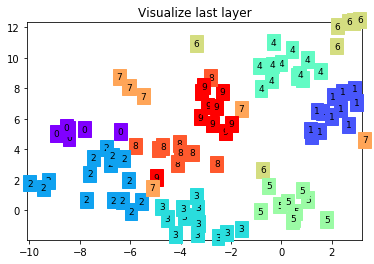

In [67]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
from sklearn.manifold import TSNE

def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
labels = y_te.numpy()[:plot_only]
plot_with_labels(low_dim_embs, labels)
plt.ioff()


In [72]:
train_input = train_input.view(-1,2,14,14)
test_input = test_input.view(-1,2,14,14)

torch.Size([1000, 2, 14, 14])

In [75]:
train_output,_ = cnn(train_input)
y_tr_pred = torch.max(train_output, 1)[1].data.squeeze()

test_output,_ = cnn(test_input) 
y_te_pred = torch.max(test_output, 1)[1].data.squeeze()

In [108]:
y_tr = (y_tr_pred[::2] <= y_tr_pred[1::2])
y_te = (y_te_pred[::2] <= y_te_pred[1::2])

In [109]:
acc_tr = (y_tr.float() == train_target.float()).sum().data.item() / y_tr.size(0)
acc_tr

0.996

In [110]:
acc_te = (y_te.float() == test_target.float()).sum().data.item() / y_te.size(0)
acc_te

0.958

----

当第一个数字小于第二个时判1



In [82]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=2,              # input height
                out_channels=16,            # n_filters
                kernel_size=3,              # filter size
                stride=1                   # filter movement/step
                              # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=3),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 3 , 1, 1),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.fc1 = nn.Linear(32 * 2 * 2, 20)
#         self.sigmoid = nn.Sigmoid()
#         self.tanh = nn.Tanh()
        self.out = nn.Linear(20, 1)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        output = self.tanh(self.out(x))
        return output   # return x for visualization  
cnn2 = CNN2()
print(cnn2)  # net architecture

CNN2(
  (conv1): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=128, out_features=20, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (out): Linear(in_features=20, out_features=1, bias=True)
)


In [83]:
mini_batch_size=100
EPOCH = 20
LR = 0.0001              # learning rate
step = 0

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
criterion = nn.CrossEntropyLoss()                       # the target label is not one-hotted

for epoch in range(EPOCH):
    for b in range(0, train_input.size(0), mini_batch_size):   # gives batch data, normalize x when iterate train_loader
        
        x_tr = train_input.narrow(0, b, mini_batch_size)
        y_tr = train_target.narrow(0, b, mini_batch_size)
        x_tr = Variable(x_tr)   # batch x
        y_tr = Variable(y_tr)   # batch y
        
        output = cnn2(x_tr)           # cnn output
        loss = criterion(output,y_tr)  # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        
    x_te = test_input.narrow(0, b, mini_batch_size).narrow(1, 0, 1)
    y_te = test_classes.narrow(0, b, mini_batch_size).narrow(1, 0, 1).squeeze()
    x_te = Variable(x_te)   
    y_te = Variable(y_te)   

    y_tr_pred = torch.max(output, 1)[1].data.squeeze()
    acc_tr = (y_tr_pred == y_tr).sum().data.item() / y_tr.size(0)
    
    test_output, last_layer = cnn(x_te)    
    y_te_pred = torch.max(test_output, 1)[1].data.squeeze()
    acc_te = (y_te_pred == y_te).sum().data.item() / y_te.size(0)
    print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item(), '| train accuracy: %.2f' % acc_tr, '| test accuracy: %.2f' % acc_te)


RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /Users/soumith/mc3build/conda-bld/pytorch_1549597882250/work/aten/src/THNN/generic/ClassNLLCriterion.c:93

---
## Siamese network

In [98]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=3,              # filter size
                stride=1                   # filter movement/step
                              # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=3),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 3 , 1, 1),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 2 * 2, 10)   # fully connected layer, output 10 classes

    def forward_once(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) 
        output = self.out(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
model = SiameseNetwork()
print(model)

SiameseNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=128, out_features=10, bias=True)
)


In [132]:
mini_batch_size=100
EPOCH = 50
LR = 0.005              # learning rate
step = 0

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
criterion = nn.ContrastiveLoss()                       # the target label is not one-hotted

for epoch in range(EPOCH):
    for b in range(0, train_input.size(0), mini_batch_size):   # gives batch data, normalize x when iterate train_loader
        
        x_tr = train_input.narrow(0, b, mini_batch_size)
        y_tr = train_classes.narrow(0, b, mini_batch_size)
        x_tr = Variable(x_tr)   # batch x
        y_tr = Variable(y_tr)   # batch y
        
        output1,output2 = model(x_tr.narrow(1,0,1),x_tr.narrow(1,1,1))               # cnn output
        loss = criterion(torch.cat([output1,output2]), torch.cat([y_tr.transpose(1,0)[0],y_tr.transpose(1,0)[1]]))   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        
    x_te = test_input.narrow(0, b, mini_batch_size).narrow(1, 0, 1)
    y_te = test_classes.narrow(0, b, mini_batch_size).narrow(1, 0, 1).squeeze()
    x_te = Variable(x_te)   
    y_te = Variable(y_te)   
    
    y_tr_pred1 = torch.max(output1, 1)[1].data.squeeze()
    y_tr_pred2 = torch.max(output2, 1)[1].data.squeeze()
    acc_tr = (y_tr_pred == y_tr).sum().data.item() / y_tr.size(0)
    
    test_output = model(x_te)    
    y_te_pred = torch.max(test_output, 1)[1].data.squeeze()
    acc_te = (y_te_pred == y_te).sum().data.item() / y_te.size(0)
    print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item(), '| train accuracy: %.2f' % acc_tr, '| test accuracy: %.2f' % acc_te)


In [133]:
loss

tensor(47.2847, grad_fn=<NllLossBackward>)

In [129]:
y_tr.transpose(1,0)[0]

tensor([6, 0, 1, 6, 3, 2, 3, 7, 4, 1, 9, 5, 7, 1, 9, 6, 3, 5, 4, 1, 1, 2, 2, 8,
        4, 8, 2, 5, 9, 2, 6, 4, 9, 0, 1, 9, 5, 3, 9, 7, 1, 5, 8, 3, 9, 8, 0, 6,
        6, 2, 1, 3, 9, 1, 8, 4, 0, 3, 5, 8, 6, 4, 7, 8, 8, 3, 7, 9, 3, 7, 5, 5,
        9, 9, 8, 5, 0, 3, 2, 1, 1, 0, 6, 2, 8, 1, 8, 9, 4, 7, 5, 7, 3, 6, 8, 9,
        9, 3, 1, 7])

In [134]:
nn.ContrastiveLoss() 

AttributeError: module 'torch.nn' has no attribute 'ContrastiveLoss'

In [135]:
from contrastive import ContrastiveLoss

ModuleNotFoundError: No module named 'contrastive'

---

In [308]:
train_input, train_target, train_classes, test_input, test_target, test_classes = helper.generate_pair_sets(1000)

In [291]:
# train_classes = train_classes.view(-1)
# train_input = train_input.view(-1,1,14,14)
augumented_data = rotated_dataset(train_input, transform)

train_input = torch.cat((train_input,augumented_data.data),0)#.view(-1,2,14,14)
train_classes = torch.cat((train_classes, train_classes), 0)
train_target = torch.cat((train_target, train_target), 0)

In [325]:
class CNN_binary(nn.Module):
    def __init__(self):
        super(CNN_binary, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (2, 14, 14)
            nn.Conv2d(
                in_channels=2,              # input height
                out_channels=16,            # n_filters
                kernel_size=2,              # filter size
                stride=1                   # filter movement/step
                              # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.Dropout(0.5),
            nn.ReLU(),                      # activation
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 2 , 1, 1),     # output shape (32, 14, 14)
            nn.Dropout(0.5),
            nn.ReLU(),                      # activation
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.conv3 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(32, 64, 2 , 1, 1),     # output shape (32, 14, 14)
            nn.Dropout(0.5),
            nn.ReLU(),                      # activation
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.fc1 = nn.Linear(32 * 3 * 3, 20)
        self.out = nn.Linear(20, 1)   # fully connected layer, output 10 classes
        self.bn1 = nn.BatchNorm2d(20)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
#         x = self.conv3(x)
#         print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        output = self.out(x).squeeze()
        return output,x    # return x for visualization  
cnn = CNN_binary()
print(cnn)  # net architecture

CNN_binary(
  (conv1): Sequential(
    (0): Conv2d(2, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=288, out_features=20, bias=True)

In [326]:
mini_batch_size=100
EPOCH = 50
LR = 0.01              # learning rate

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss1 = nn.BCEWithLogitsLoss()                       
loss2 = nn.CrossEntropyLoss()

m = nn.Sigmoid()

for epoch in range(EPOCH):
    for b in range(0, train_input.size(0), mini_batch_size):   # gives batch data, normalize x when iterate train_loader
        
        x_tr = train_input.narrow(0, b, mini_batch_size)#.narrow(1, 0, 1)
        y_tr = train_target.narrow(0, b, mini_batch_size).float()#.narrow(1, 0, 1).squeeze()
        x_tr = Variable(x_tr)   # batch x
        y_tr = Variable(y_tr)   # batch y
        y_tr_class = train_classes.narrow(0, b, mini_batch_size)
        y_tr_class = Variable(y_tr_class)
        
        output,last_layer = cnn(x_tr)               # cnn output
        loss = 0.3*loss1(output, y_tr) + 0.35*loss2(last_layer.narrow(1,0,10),y_tr_class.narrow(1,0,1).squeeze()) + 0.35*loss2(last_layer.narrow(1,10,10),y_tr_class.narrow(1,1,1).squeeze())
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        
    x_te = test_input#.narrow(0, b, mini_batch_size)#.narrow(1, 0, 1)
    y_te = test_target#.narrow(0, b, mini_batch_size).float()#.narrow(1, 0, 1).squeeze()
    x_te = Variable(x_te)   
    y_te = Variable(y_te)   

    y_tr_pred = (m(output)>0.5).float()
    acc_tr = (y_tr_pred == y_tr).sum().data.item() / y_tr.size(0)
    
    test_output,test_last_layer = cnn(x_te)
    y_te_class = test_classes#.narrow(0, b, mini_batch_size)
    y_te_class = Variable(y_te_class)
    loss_te = 0.3*loss1(test_output, y_te.float()) + 0.35*loss2(test_last_layer.narrow(1,0,10),y_te_class.narrow(1,0,1).squeeze()) + 0.35*loss2(test_last_layer.narrow(1,10,10),y_te_class.narrow(1,1,1).squeeze())
    y_te_pred = (m(test_output)>0.5).float()
    acc_te = (y_te_pred == y_te.float()).sum().data.item() / y_te.size(0)
    print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item(), '| test loss: %.4f' % loss_te.data.item())
    print('train accuracy: %.2f' % acc_tr, '| test accuracy: %.2f' % acc_te,'\n\n')


Epoch:  0 | train loss: 1.4529 | test loss: 1.3896
train accuracy: 0.65 | test accuracy: 0.62 


Epoch:  1 | train loss: 1.1783 | test loss: 1.1416
train accuracy: 0.61 | test accuracy: 0.67 


Epoch:  2 | train loss: 0.9192 | test loss: 1.0094
train accuracy: 0.64 | test accuracy: 0.69 


Epoch:  3 | train loss: 0.8752 | test loss: 0.8953
train accuracy: 0.73 | test accuracy: 0.68 


Epoch:  4 | train loss: 0.7499 | test loss: 0.8025
train accuracy: 0.71 | test accuracy: 0.72 


Epoch:  5 | train loss: 0.7494 | test loss: 0.7914
train accuracy: 0.74 | test accuracy: 0.70 


Epoch:  6 | train loss: 0.7212 | test loss: 0.7172
train accuracy: 0.69 | test accuracy: 0.72 


Epoch:  7 | train loss: 0.6901 | test loss: 0.6938
train accuracy: 0.73 | test accuracy: 0.72 


Epoch:  8 | train loss: 0.7447 | test loss: 0.7045
train accuracy: 0.73 | test accuracy: 0.72 


Epoch:  9 | train loss: 0.5436 | test loss: 0.6622
train accuracy: 0.76 | test accuracy: 0.72 


Epoch:  10 | train loss: 0.573